## Setup

In [62]:
import os
import time
from tqdm.auto import tqdm
import random
import numpy as np
import torch

import pandas as pd
import pickle
from scipy import stats
from nltk.tokenize import sent_tokenize
import json
from minicheck.minicheck import MiniCheck
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
with open("hallucination_eval_dataset.json", "r") as f:
    eval_data = json.load(f)

len(eval_data)

## Model Inference

- Currently MiniCheck models are active
- Uncomment to run HHEM 2.1

In [ ]:
doc = "A group of students gather in the school library to study for their upcoming final exams."
claim_1 = "The students are preparing for an examination."
claim_2 = "The students are on vacation."

In [ ]:
model_id = 'Bespoke-MiniCheck-7B'
model_id = 'flan-t5-large'
model_id = 'deberta-v3-large'
model_id = 'roberta-large'
model_id = 'roberta-large'
scorer = MiniCheck(
    model_name = model_id,
    enable_prefix_caching = False,
    cache_dir = './ckpts',
    # max_model_len=8192
)

In [ ]:
# scores = scorer.score(
#     docs = [doc, doc, doc]*64,
#     claims = [claim_1, claim_1, claim_2]*64,


In [ ]:
# model_id = 'vectara/hallucination_evaluation_model'

# scorer = AutoModelForSequenceClassification.from_pretrained(
#     model_id, trust_remote_code=True)
# scorer.cuda()

In [ ]:
# pairs = [
#         (doc, claim_1),
#         (doc,claim_2)
# ]

# model.predict(pairs)

In [ ]:
def run_scorer(scorer, docs, claims):
    _, scores, _, _ = scorer.score(
                        docs = docs,
                        claims =claims
                        )
    return scores

In [ ]:
# def run_scorer(scorer, docs, claims):
#     scores = scorer.predict([(doc,claim) for doc, claim in zip(docs, claims)])
#     return scores.cpu().tolist()

In [ ]:
prompt_template = "Question: {question}\nAnswer: {answer}"

In [ ]:
raw_scores = []
ground_truth = []
batch_size = 32

for start_idx in tqdm(range(0, len(eval_data), batch_size), total=len(eval_data)//batch_size):
    end_idx = min(start_idx + batch_size, len(eval_data))
    current_batch = eval_data[start_idx:end_idx]
    docs = []
    claims = []
    for doc in current_batch:
        question = doc['question']
        excerpt_paragraph = doc['excerpt_paragraph']
        true_answer = doc['true_answer']
        wrong_answer = doc['wrong_answer']
        
        if excerpt_paragraph.strip() and true_answer.strip() and wrong_answer.strip() and question.strip():
            docs.extend([excerpt_paragraph] * 2)
            true_answer_formatted = prompt_template.format(question=question, answer=true_answer)
            wrong_answer_formatted = prompt_template.format(question=question, answer=wrong_answer)
            claims.append(true_answer_formatted)
            claims.append(wrong_answer_formatted)
            ground_truth.append(1)
            ground_truth.append(0)
    
    if docs and claims:
        batch_scores = run_scorer(scorer, docs, claims)
        raw_scores.extend(batch_scores)

In [ ]:
raw_scores = np.array(raw_scores)
ground_truth = np.array(ground_truth)
thresholds = np.linspace(0, 1, 20)
results = {
    'thresholds': thresholds.tolist(),
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'predictions': {}
}

print("\nEvaluating thresholds...")
for thresh in tqdm(thresholds):
    predictions = (raw_scores > thresh).astype(int)
    
    accuracy = accuracy_score(ground_truth, predictions)
    precision = precision_score(ground_truth, predictions, zero_division=0)
    recall = recall_score(ground_truth, predictions, zero_division=0)
    f1 = f1_score(ground_truth, predictions, zero_division=0)
    
    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1'].append(f1)
    results['predictions'][f'{thresh:.3f}'] = predictions.tolist()

optimal_idx = np.argmax(results['f1'])
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = results['f1'][optimal_idx]

In [ ]:
plt.figure(figsize=(12, 7))

plt.plot(thresholds, results['accuracy'], marker='o', label='Accuracy', linewidth=2)
plt.plot(thresholds, results['precision'], marker='s', label='Precision', linewidth=2)
plt.plot(thresholds, results['recall'], marker='^', label='Recall', linewidth=2)
plt.plot(thresholds, results['f1'], marker='D', label='F1 Score', linewidth=2, color='red')

plt.axvline(x=optimal_threshold, color='black', linestyle='--', linewidth=2, 
            label=f'Optimal Threshold ({optimal_threshold:.3f})', alpha=0.7)
plt.scatter([optimal_threshold], [optimal_f1], color='red', s=200, 
            zorder=5, edgecolors='black', linewidth=1, label=f'Max F1 ({optimal_f1:.3f})')

plt.xlabel('Threshold', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)

plt.tight_layout()

plt.savefig(f'{model_id}_threshold_analysis_plot.png', dpi=300, bbox_inches='tight')

In [ ]:
optimal_predictions = results['predictions'][f'{optimal_threshold:.3f}']
optimal_threshold_predictions_metrics = {
            'accuracy': results['accuracy'][optimal_idx],
            'precision': results['precision'][optimal_idx],
            'recall': results['recall'][optimal_idx],
            'f1': results['f1'][optimal_idx]
        }
with open(f'{model_id}_optimal_threshold_predictions.json', 'w') as f:
    json.dump({
        'optimal_threshold': float(optimal_threshold),
        'predictions': optimal_predictions,
        'ground_truth': ground_truth.tolist(),
        'metrics': optimal_threshold_predictions_metrics
    }, f, indent=2)

In [ ]:
pd.Series(optimal_threshold_predictions_metrics).T

In [ ]:
print(classification_report(ground_truth, results['predictions'][f'{optimal_threshold:.3f}'], target_names=["True Answer", "False Answer"]))

In [ ]:
cm = confusion_matrix(ground_truth, results['predictions'][f'{optimal_threshold:.3f}'])

disp = ConfusionMatrixDisplay(cm)

In [ ]:
plt.figure(figsize=(7,7))
disp.plot(cmap=plt.cm.Blues, values_format='d')

### Model Tradeoff Study

In [58]:
model_scores = {'Bespoke-MiniCheck-7B':0.872267,
                'flan-t5-large': 0.886512,
                'deberta-v3-large': 0.828803,
                'roberta-large': 0.852635,
                'HHEM 2.1': 0.765843,
                
}

model_params = {'Bespoke-MiniCheck-7B': 7.74*1e9,
                'flan-t5-large': 7.80*1e8,
                'deberta-v3-large': 4.35*1e8,
                'roberta-large': 3.35*1e8,
                'HHEM 2.1': 4.39*1e8,
}

name_mapping = {
    'Bespoke-MiniCheck-7B': 'MiniCheck-7B',
    'flan-t5-large': 'Flan-T5',
    'deberta-v3-large': 'DeBERTa-v3',
    'roberta-large': 'RoBERTa',
    'HHEM 2.1': 'HHEM-2.1'
}

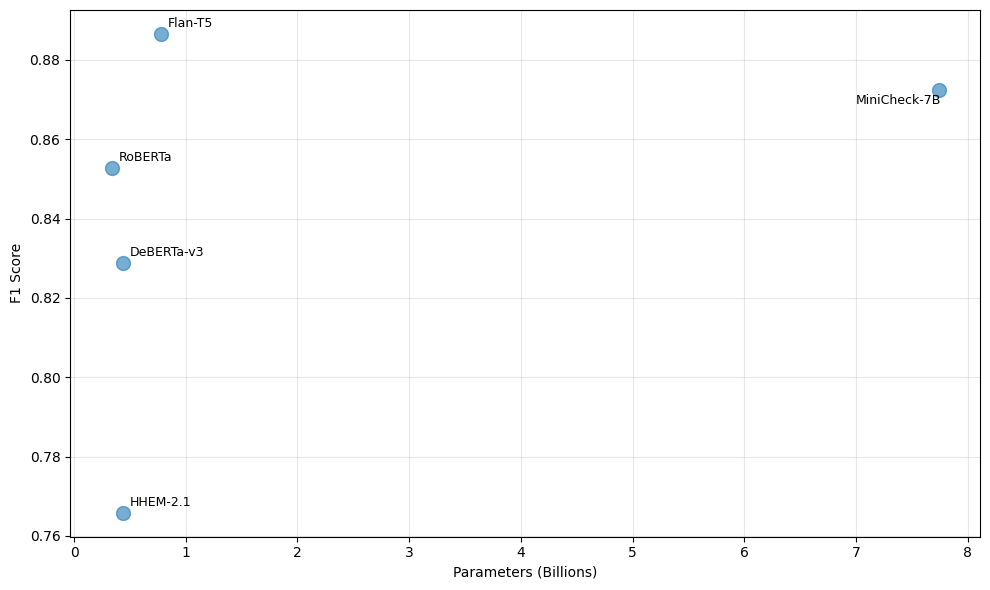

In [59]:
models = list(model_scores.keys())
scores = [model_scores[m] for m in models]
params = [model_params[m] / 1e9 for m in models] 

plt.figure(figsize=(10, 6))
plt.scatter(params, scores, s=100, alpha=0.6)

for i, model in enumerate(models):
    if model == 'Bespoke-MiniCheck-7B':
        plt.annotate(name_mapping[model], (params[i], scores[i]), xytext=(-60, -10), 
                     textcoords='offset points', fontsize=9)
    else:
        plt.annotate(name_mapping[model], (params[i], scores[i]), xytext=(5, 5), 
                 textcoords='offset points', fontsize=9)

plt.xlabel('Parameters (Billions)')
plt.ylabel('F1 Score')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('hallucination_detection_models_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [60]:
efficiency = {key: model_scores[key]/(model_params[key]/1e9) for key in model_params.keys()}
efficiency_sorted = dict(sorted(efficiency.items(), key=lambda x: x[1], reverse=True))
efficiency_sorted_renamed = {name_mapping[k]: v for k, v in efficiency_sorted.items()}

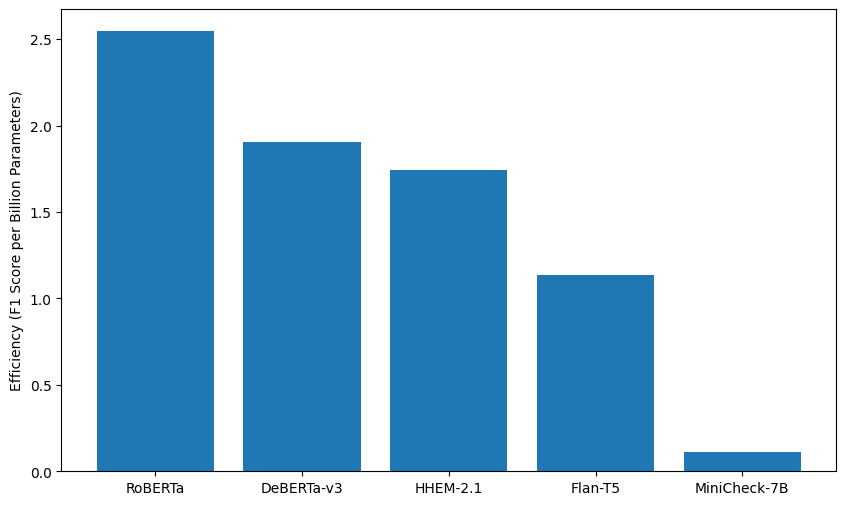

In [61]:
plt.figure(figsize=(10,6))
plt.bar(efficiency_sorted_renamed.keys(), efficiency_sorted.values())
plt.ylabel('Efficiency (F1 Score per Billion Parameters)')
plt.savefig('hallucination_detection_efficiency_comparison.png', dpi=150, bbox_inches='tight')


## Conclusion

- Minicheck RoBERTA model provides the best quality for resources